In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import difflib

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Import Data

In [5]:
# https://www.kaggle.com/datasets/prathameshf/housing-properties-in-maharashtra-big-cities
data = pd.read_csv("housing_prices_data.csv")
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
data.head()

,locality_name,region_name,price,value_per_sqft,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,3761.0,2260.0,Under Construction,Apartment,6.0,4.0,New,-1.0
1,Dombivali,Mumbai,6790000.0,13580.0,500.0,Under Construction,Apartment,4.0,2.0,New,0.0
2,Wagholi,Pune,6030000.0,7811.0,773.0,Under Construction,Apartment,5.0,3.0,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,7417.0,477.0,Ready to move,Apartment,3.0,1.0,New,0.5
4,Dombivali,Mumbai,9500000.0,10359.0,917.0,Under Construction,Apartment,5.0,3.0,New,-3.0


In [6]:
df = data.copy()

## Exploratory Data Analysis

In [7]:
df.info()
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191275 entries, 0 to 191274
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   locality_name        191274 non-null  object 
 1   region_name          191274 non-null  object 
 2   price                191274 non-null  float64
 3   value_per_sqft       191274 non-null  float64
 4   area                 191274 non-null  float64
 5   construction_status  191274 non-null  object 
 6   house_type           191274 non-null  object 
 7   total_rooms          191274 non-null  float64
 8   total_beds           191274 non-null  float64
 9   new_resale           191274 non-null  object 
 10  age                  191274 non-null  float64
dtypes: float64(6), object(5)
memory usage: 16.1+ MB


In [8]:
df.dropna(inplace=True)

In [9]:
df.duplicated().sum()

71364

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.nunique()

locality_name           1674
region_name               36
price                   7880
value_per_sqft         22507
area                    3067
construction_status        2
house_type                 6
total_rooms               13
total_beds                13
new_resale                 3
age                      101
dtype: int64

In [12]:
df['region_name'].sort_values().unique()

array(['Ahmednagar', 'Akola', 'Alibaugh', 'Amravati', 'Aurangabad',
       'Baramati', 'Beed', 'Bhandara', 'Buldana', 'Chandrapur', 'Dhule',
       'Hingoli', 'Jalgaon', 'Jalna', 'Kolhapur', 'Latur', 'Lonikand',
       'Mumbai', 'Nagpur', 'Nanded', 'Nandurbar', 'Nashik', 'Nasik',
       'Osmanabad', 'Parbhani', 'Pune', 'Raigad', 'Ratnagiri', 'Sangli',
       'Satara', 'Shirdi', 'Sindhudurg', 'Solapur', 'Vikramgad', 'Wardha',
       'Yavatmal'], dtype=object)

In [13]:
df[['construction_status']].value_counts()

construction_status
Ready to move          73757
Under Construction     46153
dtype: int64

In [14]:
df[['house_type']].value_counts()

house_type       
Apartment            113511
Studio Apartment       2965
Independent House      1475
Villa                  1375
Independent Floor       562
Penthouse                22
dtype: int64

In [15]:
df[['new_resale']].value_counts()

new_resale
New           60554
Resale        48842
old           10514
dtype: int64

In [16]:
df['room_diff'] = df.total_rooms - df.total_beds
df['room_diff'].value_counts()

2.0    119909
3.0         1
Name: room_diff, dtype: int64

In [17]:
# df.drop(df.columns[[3, 7, 11]], axis=1, inplace=True)
df.drop(['value_per_sqft', 'total_rooms', 'room_diff'], axis=1, inplace=True)
df.rename(columns = {'total_beds':'bhk'}, inplace = True)
df['new_resale'].replace(['old'], 'Resale', inplace=True)
df['region_name'].replace(['Nasik'], 'Nashik', inplace=True)
# df['price_per_sqft'] = round(df.price/df.area, 2)
df.head()

,locality_name,region_name,price,area,construction_status,house_type,bhk,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,2260.0,Under Construction,Apartment,4.0,New,-1.0
1,Dombivali,Mumbai,6790000.0,500.0,Under Construction,Apartment,2.0,New,0.0
2,Wagholi,Pune,6030000.0,773.0,Under Construction,Apartment,3.0,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,477.0,Ready to move,Apartment,1.0,New,0.5
4,Dombivali,Mumbai,9500000.0,917.0,Under Construction,Apartment,3.0,New,-3.0


In [18]:
loc_df = df.iloc[:,:2].copy()
loc_df.drop_duplicates(inplace=True)
loc_df = loc_df.sort_values(['region_name','locality_name'], ascending=[True, True]).reset_index(drop=True)

In [19]:
len(loc_df)

1725

In [20]:
loc_df_copy = loc_df.copy()
loc_df = loc_df.iloc[:-1]
loc_df_copy = loc_df_copy.iloc[1:].reset_index(drop=True)
loc_df = pd.concat([loc_df, loc_df_copy], axis="columns")
loc_df.columns.values[2] = "locality_name_1"
loc_df.columns.values[3] = "region_name_1"
loc_df.head()

,locality_name,region_name,locality_name_1,region_name_1
0,Ahinsanagar,Ahmednagar,Bhingar,Ahmednagar
1,Bhingar,Ahmednagar,Bolhegaon Suburban,Ahmednagar
2,Bolhegaon Suburban,Ahmednagar,Borude Mala,Ahmednagar
3,Borude Mala,Ahmednagar,Ghulewadi,Ahmednagar
4,Ghulewadi,Ahmednagar,Karjat,Ahmednagar


In [21]:
len(loc_df)

1724

In [22]:
loc_df['similarity_score'] = loc_df.apply(lambda row: difflib.SequenceMatcher(
    None, row['locality_name'], row['locality_name_1']).ratio(), axis = 1)

In [23]:
len(loc_df[loc_df['similarity_score']>0.7])

215

In [24]:
loc_df["road"] = loc_df.apply(lambda row: row['locality_name_1'].split(' Road')[0], axis = 1)

In [25]:
loc_sim_df = loc_df[loc_df['similarity_score']>0.7]

In [26]:
loc_same_df = loc_sim_df[loc_sim_df["road"] == loc_sim_df['locality_name']]
loc_same_df

,locality_name,region_name,locality_name_1,region_name_1,similarity_score,road
42,Kathora,Amravati,Kathora Road,Amravati,0.736842,Kathora
91,Ulkanagari,Aurangabad,Ulkanagari Road,Aurangabad,0.800000,Ulkanagari
233,Balkum,Mumbai,Balkum Road,Mumbai,0.705882,Balkum
754,Thakur Village,Mumbai,Thakur Village Road,Mumbai,0.848485,Thakur Village
813,Vinay Nagar,Mumbai,Vinay Nagar Road,Mumbai,0.814815,Vinay Nagar
880,Amar Nagar,Nagpur,Amar Nagar Road,Nagpur,0.800000,Amar Nagar
932,Dighori,Nagpur,Dighori Road,Nagpur,0.736842,Dighori
936,Friends Colony,Nagpur,Friends Colony Road,Nagpur,0.848485,Friends Colony
945,Godhani,Nagpur,Godhani Road,Nagpur,0.736842,Godhani
951,Gorewada,Nagpur,Gorewada Road,Nagpur,0.761905,Gorewada


In [27]:
for index, row in loc_same_df.iterrows():
    df.loc[(df['region_name'] == row['region_name']) & (df['locality_name'] == row['locality_name_1']),'locality_name']=row['locality_name']

In [28]:
loc_sim_df = loc_sim_df[loc_sim_df["road"] != loc_sim_df['locality_name']]

In [29]:
len(loc_sim_df)

191

In [30]:
loc_sim_df[150:]

,locality_name,region_name,locality_name_1,region_name_1,similarity_score,road
1228,Ambe Gaon,Pune,Ambegaon,Pune,0.823529,Ambegaon
1229,Ambegaon,Pune,Ambegaon 1,Pune,0.888889,Ambegaon 1
1230,Ambegaon 1,Pune,Ambegaon Budruk,Pune,0.720000,Ambegaon Budruk
1233,Anand Nagar,Pune,Anand Park,Pune,0.761905,Anand Park
1242,Bakhori,Pune,Bakori,Pune,0.923077,Bakori
1245,Balewadi,Pune,Balewadi Phata,Pune,0.727273,Balewadi Phata
1246,Balewadi Phata,Pune,Balewadi Road,Pune,0.740741,Balewadi
1264,Bhusari colony left,Pune,Bhusari colony right,Pune,0.820513,Bhusari colony right
1266,Bibwewadi,Pune,Bibwewadi Annex,Pune,0.750000,Bibwewadi Annex
1278,Charholi Budruk,Pune,Charholi Kurd,Pune,0.785714,Charholi Kurd


In [31]:
# Manually create csv referring above table
data2 = pd.read_csv("similar_locations.csv")
data2 = data2.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
data2.head()

,locality_name_1,locality_name,region_name
0,Beed Bypass Padegaon,Beed Bypass Road,Aurangabad
1,Khokurala,Khokurla,Bhandara
2,Mangalwar Peth,Manganwlarpeth,Kolhapur
3,Amboli,Amboli,Mumbai
4,Bolinj,Bolinj naka,Mumbai


In [32]:
for index, row in data2.iterrows():
    df.loc[(df['region_name'] == row['region_name']) & (df['locality_name'] == row['locality_name_1']),'locality_name']=row['locality_name']

In [33]:
df.head()

,locality_name,region_name,price,area,construction_status,house_type,bhk,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,2260.0,Under Construction,Apartment,4.0,New,-1.0
1,Dombivali,Mumbai,6790000.0,500.0,Under Construction,Apartment,2.0,New,0.0
2,Wagholi,Pune,6030000.0,773.0,Under Construction,Apartment,3.0,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,477.0,Ready to move,Apartment,1.0,New,0.5
4,Dombivali,Mumbai,9500000.0,917.0,Under Construction,Apartment,3.0,New,-3.0


In [34]:
df.to_csv('housing_prices_cleaned.csv', index=False)

In [230]:
df.describe()

,price,area,bhk,age
count,1.199100e+05,119910.000000,119910.000000,119910.000000
mean,1.472640e+07,1025.981161,1.958019,2.764767
std,3.616657e+07,704.483205,0.934229,6.893728
min,2.200000e+05,113.000000,0.000000,-14.000000
25%,4.800000e+06,640.000000,1.000000,0.000000
50%,7.900000e+06,900.000000,2.000000,2.000000
75%,1.470000e+07,1161.000000,2.000000,3.500000
max,9.999000e+08,20000.000000,15.000000,122.500000


<AxesSubplot:>

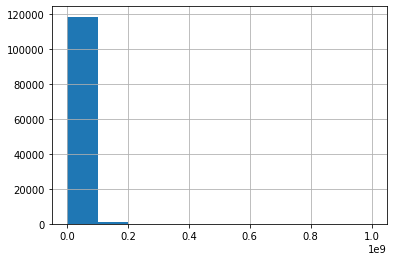

In [232]:
df['price'].hist()

In [233]:
len(df[df['price']>200000000])

434

<AxesSubplot:>

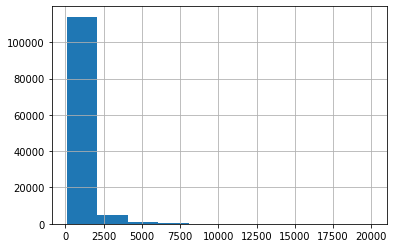

In [234]:
df['area'].hist()

<AxesSubplot:>

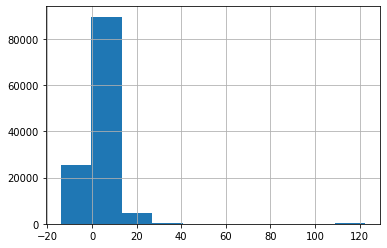

In [235]:
df['age'].hist()

In [236]:
df.corr()

,price,area,bhk,age
price,1.000000,0.621775,0.403029,0.045634
area,0.621775,1.000000,0.765080,0.100260
bhk,0.403029,0.765080,1.000000,0.054321
age,0.045634,0.100260,0.054321,1.000000


In [237]:
features = df.drop(['price','age'], axis=1).copy()
features.head()

,locality_name,region_name,area,construction_status,house_type,bhk,new_resale
0,Tarwala Nagar,Nashik,2260.0,Under Construction,Apartment,4.0,New
1,Dombivali,Mumbai,500.0,Under Construction,Apartment,2.0,New
2,Wagholi,Pune,773.0,Under Construction,Apartment,3.0,New
3,Ambegaon Budruk,Pune,477.0,Ready to move,Apartment,1.0,New
4,Dombivali,Mumbai,917.0,Under Construction,Apartment,3.0,New


In [238]:
target = df['price'].copy()
target.head()

0    8499000.0
1    6790000.0
2    6030000.0
3    3537000.0
4    9500000.0
Name: price, dtype: float64

## Transformations

In [239]:
# features.area = np.log(features.area)
# features.value_per_sqft = np.log(features.value_per_sqft)

In [240]:
le = preprocessing.LabelEncoder()

In [241]:
for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = le.fit_transform(features[col]).astype(int)

In [242]:
features = preprocessing.MinMaxScaler().fit_transform(features)

In [243]:
features[:1]

array([[0.84332085, 0.61764706, 0.10795997, 1.        , 0.        ,
        0.26666667, 0.        ]])

## Training

In [244]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=33)

In [245]:
#Simple Linear Regression
LR = LinearRegression()
LR = LR.fit(X_train, Y_train)
Y_predict = LR.predict(X_test)

lr_error = mean_squared_error(Y_test,Y_predict)
lr_error

821547836213198.6

In [246]:
r2 = r2_score(Y_test, Y_predict)
r2

0.4330727840866301

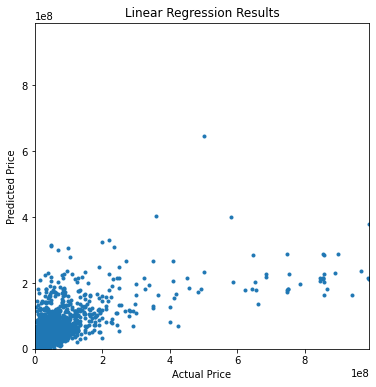

In [247]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(Y_test, Y_predict, 
         marker='o', ls='', ms=3.0)

lim = (0, Y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');